In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
# from stratx.plot import *
# from stratx.ice import *

%config InlineBackend.figure_formats = ['png']

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders


def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [2]:
def load_rent():
    """
    *Data use rules prevent us from storing this data in this repo*. Download the data
    set from Kaggle. (You must be a registered Kaggle user and must be logged in.)
    Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
    and save `train.json`
    :return:
    """
    df = pd.read_json('data/train.json')

    # Create ideal numeric data set w/o outliers etc...
    df = df[(df.price > 1_000) & (df.price < 10_000)]
    df = df[df.bathrooms <= 4]  # There's almost no data for above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df = df.sort_values('created')
    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price']]

    return df_rent

In [3]:
def leaf_samples(rf, X:np.ndarray):
    """
    Return a list of arrays where each array is the set of X sample indexes
    residing in a single leaf of some tree in rf forest.
    """
    ntrees = len(rf.estimators_)
    leaf_ids = rf.apply(X) # which leaf does each X_i go to for each tree?
    d = pd.DataFrame(leaf_ids, columns=[f"tree{i}" for i in range(ntrees)])
    d = d.reset_index() # get 0..n-1 as column called index so we can do groupby
    """
    d looks like:
        index	tree0	tree1	tree2	tree3	tree4
    0	0	    8	    3	    4	    4	    3
    1	1	    8	    3	    4	    4	    3
    """
    leaf_samples = []
    for i in range(ntrees):
        """
        Each groupby gets a list of all X indexes associated with same leaf. 4 leaves would
        get 4 arrays of X indexes; e.g.,
        array([array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]),
               array([21, 22, 23, 24, 25, 26, 27, 28, 29]), ... )
        """
        sample_idxs_in_leaf = d.groupby(f'tree{i}')['index'].apply(lambda x: x.values)
        leaf_samples.extend(sample_idxs_in_leaf) # add [...sample idxs...] for each leaf
    return leaf_samples

In [22]:
df_rent = load_rent()
df_rent = df_rent[-10_000:]  # get a small subsample since SVM is slowwww
df_rent['latitude'] = (df_rent['latitude']-40)*100 # shift so easier to read
df_rent.head(3)

,bedrooms,bathrooms,latitude,longitude,price
38745,0,1.0,69.27,-73.9860,2855
38613,1,1.0,79.63,-73.9306,1550
21781,2,1.0,68.93,-73.9918,3500


In [23]:
X = df_rent.drop('price', axis=1)
y = df_rent['price']

In [35]:
def collect_point_betas(X, y, colname, leaves, nbins):
    point_betas = np.full(shape=(len(X),), fill_value=np.nan)
    for samples in leaves: # samples is set of obs indexes that live in a single leaf
        leaf_all_x = X.iloc[samples]
        leaf_x = leaf_all_x[colname].values
        leaf_y = y.iloc[samples].values
        # Right edge of last bin is max(leaf_x) but that means we ignore the last value
        # every time. Tweak domain right edge a bit so max(leaf_x) falls in last bin.
        last_bin_extension = 0.0000001
        domain = (np.min(leaf_x), np.max(leaf_x)+last_bin_extension)
        bins = np.linspace(*domain, num=nbins+1, endpoint=True)
#         print('bins', bins)
        binned_idx = np.digitize(leaf_x, bins) # bin number for values in leaf_x
#         print(leaf_x, '->', leaf_y)
#         print(f"leaf samples: {samples}, binned_idx: {binned_idx}")
        for b in range(1, len(bins)+1):
            bin_x = leaf_x[binned_idx == b]
            bin_y = leaf_y[binned_idx == b]
            bin_obs_idx = np.digitize(bin_x, bins) # bin number for values in leaf_x
            if len(bin_x)<2: # either no or too little data
    #             print(f'ignoring {bin_x} -> {bin_y}')
                continue
            r = (np.min(bin_x), np.max(bin_x))
            if np.isclose(r[0], r[1]):
    #             print(f'ignoring {bin_x} -> {bin_y} for same range')
                continue
            lm = LinearRegression()
    #         bin_x = bin_x.reshape(-1, 1)
            leaf_obs_idx_for_bin = np.nonzero((leaf_x>=bins[b-1]) &(leaf_x<bins[b]))
            leaf_x_in_bin = leaf_x[leaf_obs_idx_for_bin]
            obs_idx = samples[leaf_obs_idx_for_bin]
#             print("\tx in range", leaf_x_in_bin, leaf_obs_idx_for_bin, "obs idx", obs_idx)
            lm.fit(bin_x.reshape(-1, 1), bin_y)
#             print(f'\tbin{b}', bin_x, '->', bin_y, 'beta', lm.coef_[0])
            point_betas[obs_idx] = lm.coef_[0]
    return point_betas

def foo(X, y, colname, ntrees = 1, min_samples_leaf=10, bootstrap=False, max_features=1.0, nbins=2):
    rf = RandomForestRegressor(n_estimators=ntrees,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap = bootstrap,
                               max_features = max_features)
    rf.fit(X.drop(colname, axis=1), y)
    print(rf)
    leaves = leaf_samples(rf, X.drop(colname, axis=1))
    nnodes = rf.estimators_[0].tree_.node_count
    print(f"Partitioning 'x not {colname}': {nnodes} nodes in (first) tree, "
          f"{len(rf.estimators_)} trees, {len(leaves)} total leaves")

    point_betas = collect_point_betas(X, y, colname, leaves, nbins)
    Xbetas = np.vstack([X[colname].values, point_betas]).T # get x_c, beta matrix
    Xbetas = Xbetas[Xbetas[:,0].argsort()] # sort by x coordinate
    return Xbetas

In [36]:
Xbetas = foo(X, y, 'bedrooms', nbins=2)
Xbetas#[0:30]

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=1.0, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Partitioning 'x not bedrooms': 1397 nodes in (first) tree, 1 trees, 699 total leaves


array([[   0.        ,           nan],
       [   0.        ,           nan],
       [   0.        ,  775.61818182],
       ...,
       [   6.        ,  900.33333333],
       [   8.        ,           nan],
       [   8.        , -550.        ]])

In [26]:
np.unique(Xbetas[:,0])

array([0., 1., 2., 3., 4., 5., 6., 8.])

In [27]:
for x in np.unique(Xbetas[:,0]):
    print(x, np.nanmean(Xbetas[Xbetas[:,0]==x]))

0.0 249.52163288615623
1.0 243.6280085875399
2.0 225.55010982389925
3.0 193.245222191391
4.0 218.0977196353945
5.0 488.5478603603604
6.0 144.23333333333335
8.0 -177.99999999999991


In [78]:
nbins_smoothing = 9
x = Xbetas[:,0]
#slopes = Xbetas[:,1]
domain = (np.min(x), np.max(x)) # ignores any max(x) points as no slope info after that
bins_smoothing = np.linspace(*domain, num=nbins_smoothing+1, endpoint=True)
# or use all unique values as bin edges
#bins_smoothing = np.array(sorted(np.unique(x)))
binned_idx = np.digitize(x, bins_smoothing) # bin number for values in leaf_x

noinfo = np.isnan(Xbetas[:,1])
Xbetas = Xbetas[~noinfo]

from scipy.stats import binned_statistic
avg_slopes_per_bin, _, _ = binned_statistic(x=Xbetas[:,0], values=Xbetas[:,1], bins=bins_smoothing, statistic='mean')
# avg_slopes_per_bin might have nan for empty bins
bin_deltas = np.diff(bins_smoothing)
print('bins_smoothing', bins_smoothing, ', deltas', bin_deltas)
avg_slopes_per_bin *= bin_deltas
print('avgslopes', avg_slopes_per_bin)
curve = np.nancumsum(avg_slopes_per_bin)
curve = np.concatenate([np.array([0]), curve])  # we start at 0 for min(x)
print('curve cumsum   ', curve)

bins_smoothing [0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ] , deltas [0.88888889 0.88888889 0.88888889 0.88888889 0.88888889 0.88888889
 0.88888889 0.88888889 0.88888889]
avgslopes [ 502.35204079  481.58188301  522.19129177  416.05777219  558.45677978
  939.93572985  414.91358025           nan -488.88888889]
curve cumsum    [   0.          502.35204079  983.9339238  1506.12521557 1922.18298776
 2480.63976754 3420.57549739 3835.48907763 3835.48907763 3346.60018875]


  0.0,  0.0,  0.0
  0.9,502.4,502.4
  1.8,983.9,481.6
  2.7,1506.1,522.2
  3.6,1922.2,416.1
  4.4,2480.6,558.5
  5.3,3420.6,939.9
  6.2,3835.5,414.9
  7.1,3835.5,  nan SKIP
  8.0,3346.6,-488.9


[(0.0, 0.0),
 (0.8888888888888888, 502.35204079492013),
 (1.7777777777777777, 983.9339238004862),
 (2.6666666666666665, 1506.1252155746502),
 (3.5555555555555554, 1922.1829877600944),
 (4.444444444444445, 2480.639767540252),
 (5.333333333333333, 3420.575497387746),
 (6.222222222222221, 3835.489077634659),
 (8.0, 3346.6001887457705)]

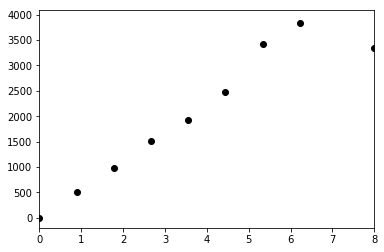

In [79]:
# manual cumsum (not needed)
plot_x = []
plot_y = []
cumslope = 0.0
avg_slopes_per_bin = np.concatenate([np.array([0]), avg_slopes_per_bin])  # we start at 0 for min(x)
for x,slope in zip(bins_smoothing,avg_slopes_per_bin):
    if np.isnan(slope):
        print(f"{x:5.1f},{cumslope:5.1f},{slope:5.1f} SKIP")
        continue
    cumslope += slope
    plot_x.append(x)
    plot_y.append(cumslope)
    print(f"{x:5.1f},{cumslope:5.1f},{slope:5.1f}")
    plt.scatter([x],[cumslope], c='black')
plt.xlim(0,8)
list(zip(plot_x,plot_y))

has_slope_info (array([0, 1, 2, 3, 4, 5, 6, 8]),) no slope (array([], dtype=int64),)
bins      [0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 7.11111111]
curve [   0.          502.35204079  983.9339238  1506.12521557 1922.18298776
 2480.63976754 3420.57549739 3835.48907763]


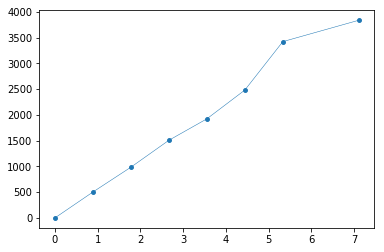

In [76]:
has_slope_info = np.nonzero(~np.isnan(avg_slopes_per_bin))
print('has_slope_info', has_slope_info, 'no slope', np.nonzero(np.isnan(curve)))
print('bins     ', bins_smoothing[has_slope_info])
print('curve', curve[has_slope_info])

bins_smoothing = bins_smoothing[has_slope_info]
curve = curve[has_slope_info]

plt.scatter(bins_smoothing, curve, s=15)
plt.plot(bins_smoothing, curve, lw=.5)
#plt.ylim(0,4000)